In [1]:
"""
Solución Optimizada para Predicción de Precios de Viviendas
"""
 
# ==================== 1. IMPORTACIONES ====================
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
 


In [2]:
# ==================== 2. PREPROCESAMIENTO MEJORADO ====================
# Cargar datos
 
 
url = "Housing.csv"  # Reemplazar con la URL correcta
data = pd.read_csv(url)
 
 
# Limpieza y transformaciones
def preprocess_data(df):
    # Convertir variables binarias
    binary_cols = ['mainroad', 'guestroom', 'basement', 
                   'hotwaterheating', 'airconditioning', 'prefarea']
    df[binary_cols] = df[binary_cols].replace({'yes': 1, 'no': 0}).astype(float)
    # One-hot encoding
    df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True)
    # Eliminar outliers extremos
    df = df[(df['price'] >= df['price'].quantile(0.05)) & 
            (df['price'] <= df['price'].quantile(0.95))]
    # Transformaciones logarítmicas
    df['price_log'] = np.log1p(df['price'])
    df['area_log'] = np.log1p(df['area'])
    # Ingeniería de características
    df['area_per_bedroom'] = df['area'] / (df['bedrooms'] + 1)
    df['bath_bed_ratio'] = df['bathrooms'] / (df['bedrooms'] + 1)
    df['luxury_score'] = data[['hotwaterheating', 'airconditioning', 'prefarea']].sum(axis=1)
    return df
 
data = preprocess_data(data)
 
 
# Definir características y objetivo
features = [
    'area_log', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
    'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
    'parking', 'prefarea', 'furnishingstatus_semi-furnished',
    'furnishingstatus_unfurnished', 'area_per_bedroom', 'bath_bed_ratio','luxury_score'
]
target = 'price_log'
 
X = data[features]
y = data[target]
 
from sklearn.ensemble import IsolationForest
 
iso_forest = IsolationForest(contamination=0.02, random_state=42)
outlier_mask = iso_forest.fit_predict(X) == 1
X = X[outlier_mask]
y = y[outlier_mask]
 


C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_10064\882688280.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[binary_cols] = df[binary_cols].replace({'yes': 1, 'no': 0}).astype(float)


In [3]:
def augment_data(X, y, num_samples=1500):
    np.random.seed(42)
    # Interpolación entre puntos reales
    idx1 = np.random.randint(0, len(X), num_samples)
    idx2 = np.random.randint(0, len(X), num_samples)
    alpha = np.random.uniform(0, 1, num_samples).reshape(-1, 1)
    X_aug = alpha * X.iloc[idx1].values + (1 - alpha) * X.iloc[idx2].values
    y_aug = alpha.flatten() * y.iloc[idx1].values + (1 - alpha.flatten()) * y.iloc[idx2].values
    # Agregar ruido gaussiano
    noise_X = np.random.normal(0, 0.01, X_aug.shape)
    noise_y = np.random.normal(0, 0.01, y_aug.shape)
    X_aug += noise_X
    y_aug += noise_y
    X_aug = pd.DataFrame(X_aug, columns=X.columns)
    y_aug = pd.Series(y_aug, name=y.name)
    return X_aug, y_aug

In [4]:
# División de datos (primero)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Aplicar aumentación solo sobre el entrenamiento
X_aug, y_aug = augment_data(X_train, y_train, num_samples=3500)

# Combinar los datos augmentados con el entrenamiento
X_train = pd.concat([X_train, X_aug], axis=0)
y_train = pd.concat([y_train, y_aug], axis=0)

# Escalado robusto
scaler_X = RobustScaler()
scaler_y = RobustScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

from sklearn.preprocessing import PolynomialFeatures
# Transformaciones polinómicas
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)


In [5]:
# ==================== 3. ARQUITECTURA DEL MODELO MEJORADA ====================
def build_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu', kernel_regularizer=l2(0.005)),
        BatchNormalization(),
        Dense(1, activation='linear')
    ])
    optimizer = Adam(
        learning_rate=0.0005,
        clipvalue=1.0  # Prevenir exploding gradients
    )
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',  # Más robusto a outliers
        metrics=['mae']
    )
    return model
 
model = build_model((X_train_scaled.shape[1],))
 


c:\Users\Alumno_AI\.conda\envs\house\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# ==================== 4. ENTRENAMIENTO CON CALLBACKS ====================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)
 
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5
)
 
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=350,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)
 


Epoch 1/350
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.4650 - mae: 0.8204 - val_loss: 1.7033 - val_mae: 0.4716 - learning_rate: 5.0000e-04
Epoch 2/350
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7955 - mae: 0.5647 - val_loss: 1.5070 - val_mae: 0.4074 - learning_rate: 5.0000e-04
Epoch 3/350
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6471 - mae: 0.5044 - val_loss: 1.4286 - val_mae: 0.3967 - learning_rate: 5.0000e-04
Epoch 4/350
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5330 - mae: 0.4773 - val_loss: 1.3427 - val_mae: 0.3732 - learning_rate: 5.0000e-04
Epoch 5/350
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3940 - mae: 0.4261 - val_loss: 1.2518 - val_mae: 0.3506 - learning_rate: 5.0000e-04
Epoch 6/350
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3188 - mae: 0.4243 - val_loss: 1.1771 - val_mae: 0.3414 - learning_rate: 5.0000e-04
Epoch 7/350
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2248 - mae: 0.4007 - val_loss: 1.1033 - val_mae: 0.3313 - learning_ra

In [7]:
# ==================== 5. EVALUACIÓN Y POST-PROCESAMIENTO ====================
# Predicciones
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_pred_price = np.expm1(y_pred)  # Revertir transformación logarítmica
 
# Valores reales
y_test_inv = scaler_y.inverse_transform(y_test_scaled)
y_test_price = np.expm1(y_test_inv)
 
# Cálculo de métricas
rmse = np.sqrt(mean_squared_error(y_test_price, y_pred_price))
r2 = r2_score(y_test_price, y_pred_price)
avg_price = np.mean(y_test_price)
rmse_percentage = (rmse / avg_price) * 100
 
print("\nResultados Finales Mejorados:")
print(f"RMSE: {rmse:.2f} ({rmse_percentage:.2f}% del precio promedio)")
print(f"R²: {r2:.4f}")
 


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Resultados Finales Mejorados:
RMSE: 1152375.30 (25.02% del precio promedio)
R²: 0.4168


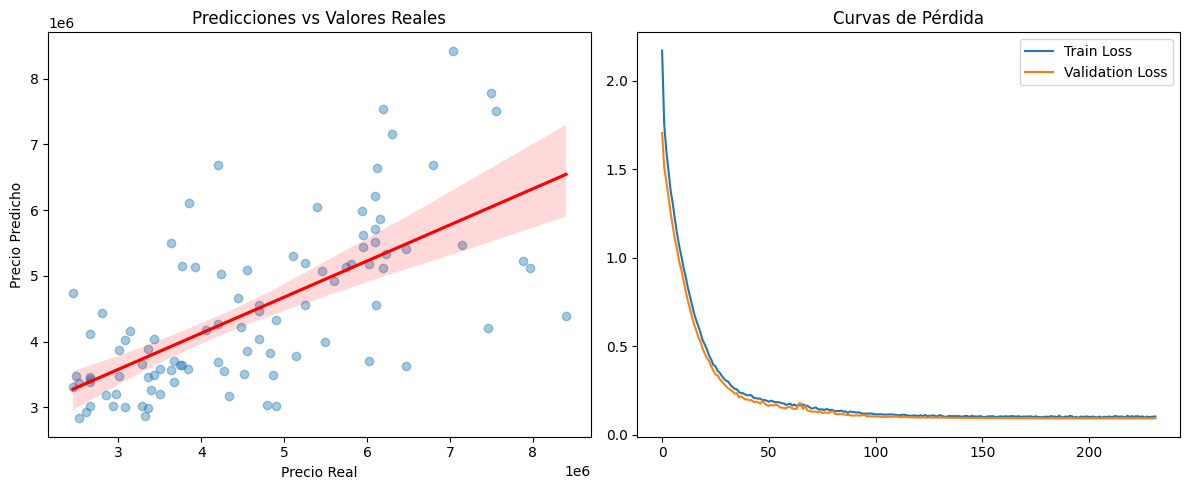

In [8]:
# ==================== 6. VISUALIZACIONES ====================
plt.figure(figsize=(12, 5))
 
# Gráfico de predicciones vs reales
plt.subplot(1, 2, 1)
sns.regplot(x=y_test_price.flatten(), y=y_pred_price.flatten(), 
            line_kws={'color': 'red'}, scatter_kws={'alpha': 0.4})
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')
 
# Gráfico de pérdidas
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Curvas de Pérdida')
plt.legend()
 
plt.tight_layout()
plt.savefig('performance_optimizado.png')
plt.show()
 


In [ ]:
# ==================== 7. GUARDAR MODELO ====================
model.save('modelo_optimizado.h5')